## Nanomole-scale high-throughput chemistry for the synthesis of complex molecules

DOI: 10.1126/science.1259203

Alexander Buitrago Santanilla, Erik L. Regalado, Tony Pereira, Michael Shevlin, Kevin Bateman, Louis-Charles Campeau, Jonathan Schneeweis, Simon Berritt, Zhi-Cai Shi, Philippe Nantermet, Yong Liu, Roy Helmy, Christopher J. Welch, Petr Vachal, Ian W. Davies, Tim Cernak, Spencer D. Dreher *Science* **2015**, *347*, 6217, 49-53. https://www.sciencemag.org/lookup/doi/10.1126/science.1259203

Submission test by Michael R. Maser, Division of Chemistry and Chemical Engineering, California Institute of Technology, Pasadena, CA. mmaser@caltech.edu

Import schema and helper functions

In [1]:
import ord_schema
from datetime import datetime
from ord_schema.proto import dataset_pb2
from ord_schema.proto import reaction_pb2
from ord_schema.units import UnitResolver
from ord_schema import validations
from ord_schema import message_helpers
from ord_schema.visualization import drawing

unit_resolver = UnitResolver()

In [2]:
from tqdm import tqdm

In [3]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from IPython.display import SVG

## Load the dataset

In [4]:
# Create pandas dataframe
data = pd.read_excel('1259203_Datafiles.xlsx', 'Data S2- Experiment 2')

# View dataframe
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,ArBr,Prod,Nu,Pd/IS
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.33032,1.206548e+06,0.000000e+00,2.638835e+06,0.000000
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.34177,1.130276e+06,0.000000e+00,2.474074e+06,0.000000
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.13944,1.099909e+06,0.000000e+00,2.387052e+06,0.000000
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.17048,1.111019e+06,3.268438e+04,2.511884e+06,0.137295
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232566.53610,1.116529e+06,0.000000e+00,2.576513e+06,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178233.56101,0.000000e+00,3.046576e+06,NaN,17.093165
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229583.53543,2.540502e+05,2.789535e+06,NaN,12.150413
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.15883,8.155211e+05,4.537288e+05,NaN,2.244058
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201367.67531,6.228828e+05,1.109048e+06,NaN,5.507575


## Identify and replace coded reaction components

In [5]:
# Extract unique values for each reaction component
reagent_dict = {}
component_types = ['Electrophile', 'Nucleophile', 'Catalyst', 'Base']

# Create dictionary for each component set with names and SMILES
for component in component_types:
    component_dict = {}
    for unique in list(data[component].unique()):
        component_dict[unique] = 'placeholder'
    reagent_dict[f'{component}s'] = component_dict    

# Check length of each list 
for reagent, uniques in reagent_dict.items():
    print(f'{reagent} count: {len(uniques)}')

reagent_dict

Electrophiles count: 1
Nucleophiles count: 16
Catalysts count: 16
Bases count: 6


{'Electrophiles': {'bromide 22': 'placeholder'},
 'Nucleophiles': {'amine S1': 'placeholder',
  'aniline S2': 'placeholder',
  'amide S4': 'placeholder',
  'sulfonamide S5': 'placeholder',
  'aminopyridine S3': 'placeholder',
  'amidine S6': 'placeholder',
  'tBu carbamate S7': 'placeholder',
  'indazole S8': 'placeholder',
  'alcohol S9': 'placeholder',
  'phenol S10': 'placeholder',
  'thiophenol S11': 'placeholder',
  'phosphine S12': 'placeholder',
  'boronate S14/water': 'placeholder',
  'malonate S13': 'placeholder',
  'alkene S15': 'placeholder',
  'alkyne S16': 'placeholder'},
 'Catalysts': {'BINAP Pd G3 30': 'placeholder',
  'DPPF Pd G3 31': 'placeholder',
  'XantPhos Pd G2 32': 'placeholder',
  'tBu3P Pd G2 33': 'placeholder',
  'PPA Pd G3 34': 'placeholder',
  'Aphos Pd G3 35': 'placeholder',
  'Xphos Pd G3 36': 'placeholder',
  'RuPhos Pd G2 37': 'placeholder',
  'DTBPF Pd G3 38': 'placeholder',
  'J009  Pd G3 39': 'placeholder',
  'MorDalPhos Pd G3 40': 'placeholder',
  'B

In [6]:
# Add product identifier (dependent on nucleophile)
# Create nucleophile to product mapping
product_dict = {}
reagent_dict['Products'] = {}
for i, nucleophile in enumerate(reagent_dict['Nucleophiles'].keys()):
    # Create product for each nucleophile
    product_dict[nucleophile] = f'Product_{i}'
    
    # Add products to reagent_dict
    reagent_dict['Products'][f'Product_{i}'] = 'placeholder'

# Add product column to dataframe using map
data['Product'] = data['Nucleophile'].map(product_dict)

# Add reaction type identifier (dependent on nucleophile)
reaction_type_dict = {
    'amine S1': 'Buchwald-Hartwig amination',
    'aniline S2': 'Buchwald-Hartwig amination',
    'amide S4': 'Buchwald-Hartwig amination',
    'sulfonamide S5': 'Buchwald-Hartwig amination',
    'aminopyridine S3': 'Buchwald-Hartwig amination',
    'amidine S6': 'Buchwald-Hartwig amination',
    'tBu carbamate S7': 'Buchwald-Hartwig amination',
    'indazole S8': 'Buchwald-Hartwig amination',
    'alcohol S9': 'Buchwald-Hartwig etherification',
    'phenol S10': 'Buchwald-Hartwig etherification',
    'thiophenol S11': 'Buchwald-Hartwig thioetherification',
    'phosphine S12': 'Buchwald-Hartwig phosphination',
    'boronate S14/water': 'Suzuki-Miyaura coupling',
    'malonate S13': 'Pd-catalyzed enolate arylation',
    'alkene S15': 'Heck coupling',
    'alkyne S16': 'Sonogashira coupling',
}

# Add reaction type column to dataframe using map
data['Reaction_type'] = data['Nucleophile'].map(reaction_type_dict)

# View changes
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,ArBr,Prod,Nu,Pd/IS,Product,Reaction_type
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.33032,1.206548e+06,0.000000e+00,2.638835e+06,0.000000,Product_0,Buchwald-Hartwig amination
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.34177,1.130276e+06,0.000000e+00,2.474074e+06,0.000000,Product_0,Buchwald-Hartwig amination
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.13944,1.099909e+06,0.000000e+00,2.387052e+06,0.000000,Product_0,Buchwald-Hartwig amination
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.17048,1.111019e+06,3.268438e+04,2.511884e+06,0.137295,Product_0,Buchwald-Hartwig amination
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232566.53610,1.116529e+06,0.000000e+00,2.576513e+06,0.000000,Product_0,Buchwald-Hartwig amination
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178233.56101,0.000000e+00,3.046576e+06,NaN,17.093165,Product_15,Sonogashira coupling
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229583.53543,2.540502e+05,2.789535e+06,NaN,12.150413,Product_15,Sonogashira coupling
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.15883,8.155211e+05,4.537288e+05,NaN,2.244058,Product_15,Sonogashira coupling
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201367.67531,6.228828e+05,1.109048e+06,NaN,5.507575,Product_15,Sonogashira coupling


In [7]:
# See updated reagent_dict
reagent_dict

{'Electrophiles': {'bromide 22': 'placeholder'},
 'Nucleophiles': {'amine S1': 'placeholder',
  'aniline S2': 'placeholder',
  'amide S4': 'placeholder',
  'sulfonamide S5': 'placeholder',
  'aminopyridine S3': 'placeholder',
  'amidine S6': 'placeholder',
  'tBu carbamate S7': 'placeholder',
  'indazole S8': 'placeholder',
  'alcohol S9': 'placeholder',
  'phenol S10': 'placeholder',
  'thiophenol S11': 'placeholder',
  'phosphine S12': 'placeholder',
  'boronate S14/water': 'placeholder',
  'malonate S13': 'placeholder',
  'alkene S15': 'placeholder',
  'alkyne S16': 'placeholder'},
 'Catalysts': {'BINAP Pd G3 30': 'placeholder',
  'DPPF Pd G3 31': 'placeholder',
  'XantPhos Pd G2 32': 'placeholder',
  'tBu3P Pd G2 33': 'placeholder',
  'PPA Pd G3 34': 'placeholder',
  'Aphos Pd G3 35': 'placeholder',
  'Xphos Pd G3 36': 'placeholder',
  'RuPhos Pd G2 37': 'placeholder',
  'DTBPF Pd G3 38': 'placeholder',
  'J009  Pd G3 39': 'placeholder',
  'MorDalPhos Pd G3 40': 'placeholder',
  'B

## Add SMILES representations for dataset molecules

### SMILES testing for metal complexes
RDKit SMILES parsing fails for ChemDraw-generated SMILES of plainly drawn metal complexes due to valence rules on N atoms. Using dative bonds in ChemDraw fixes this problem but generates charged species to satisfy valence rules. ChemDraw's syntax for ferrocene complexes leads to RDKit parsing failures. PubChem "canonical" SMILES for metal complexes treats each substructure as a separate component (e.g., metals, ligands, ions), leading to a salt-like representation of the compounds. Ultimately found that using ChemDraw to generate SMILES with neutral single bonds to ligands, generating dative '<-' bonds programmatically (see below), and drawing ferrocenes explicitly as cyclopentadienyl-anion-sandwiched Fe atoms led to the most reasonable representations. <br>
See the discussion here for the shortcomings of SMILES in representing metallocenes: https://chemistry.stackexchange.com/questions/20486/what-would-be-smiles-notation-for-a-compound-with-delocalized-bonding<br>
Structures are drawn in ./Santanilla_component_smiles.cdx and Chemdraw generated SMILES (non-canonical) are copied to ./experiment_2_molecules.csv

### Add SMILES to dataset
SMILES are imported in non-canonical format as generated by ChemDraw. SMILES are canonicalized by RDKit below before including in dataset

In [8]:
# Load SMILES info from Chemdraw .csv
smiles_data = pd.read_csv('experiment_2_molecules.csv')
smiles_data

,dataset_name,non_canonical_smiles
0,bromide 22,BrC1=CN=CC=C1
1,amine S1,CC(N)CCC1=CC=CC=C1
2,aniline S2,NC1=CC=CC=C1
3,amide S4,NC(C1=CC=CC=C1)=O
4,sulfonamide S5,NS(C1=CC=CC=C1)(=O)=O
5,aminopyridine S3,NC1=NC=C(C2=CC=CC=C2)C=C1
6,amidine S6,NC(CC1=CC=CC=C1)=N
7,tBu carbamate S7,NC(OC(C)(C)C)=O
8,indazole S8,C12=CC=CC=C1NN=C2
9,alcohol S9,OCCCC1=CC=CC=C1


### Handle dative bonds in metal complexes
From Greg Landrum at RDKit: https://www.rdkit.org/docs/Cookbook.html#organometallics-with-dative-bonds<br>
Added phosphorous to dative atom list in set_dative_bonds and added new function has_transition_metal

In [9]:
def is_transition_metal(atom):
    """
    Determines if an atom is a transition metal
    
    ARGUMENTS:
        (rdkit.Chem.rdchem.Atom)atom: atom object for the atom in question
        
    RETURNS:
        (bool): boolean describing whether atomic number of atom is in 
                one of transition-metal ranges
    """
    n = atom.GetAtomicNum()
    return (n>=22 and n<=29) or (n>=40 and n<=47) or (n>=72 and n<=79)

def has_transition_metal(mol):
    """
    Determines if a molecule has a transition metal
    
    ARGUMENTS:
        (rdkit.Chem.rdchem.Mol)mol: mol object for the molecule in question
        
    RETURNS:
        (bool): boolean describing whether molecule has an atom with 
                atomic number in the transition-metal ranges
    """
    for atom in mol.GetAtoms():
        if is_transition_metal(atom):
            return True
    return False

def set_dative_bonds(mol, fromAtoms=(7,8,15)):
    """ 
    Convert metal-ligand bonds to dative. Replaces some single bonds between
    metals and atoms with atomic numbers in fromAtoms with dative bonds.
    The replacement is only done if the atom has "too many" bonds

    ARGUMENTS:
        (rdkit.Chem.rdchem.Mol)mol: molecule to convert dative bonds
        (tuple)fromAtoms: atomic numbers corresponding to metal-bound atoms
                            that should have bonds converted to dative
                            
    RETURNS:
        (rdkit.Chem.rdchem.Mol)rwmol: the modified molecule

    """
    pt = Chem.GetPeriodicTable()
    rwmol = Chem.RWMol(mol)
    rwmol.UpdatePropertyCache(strict=False)
    metals = [at for at in rwmol.GetAtoms() if is_transition_metal(at)]
    for metal in metals:
        for nbr in metal.GetNeighbors():
            if nbr.GetAtomicNum() in fromAtoms and \
               nbr.GetExplicitValence()>pt.GetDefaultValence(nbr.GetAtomicNum()) and \
               rwmol.GetBondBetweenAtoms(nbr.GetIdx(),metal.GetIdx()).GetBondType() == Chem.BondType.SINGLE:
                rwmol.RemoveBond(nbr.GetIdx(),metal.GetIdx())
                rwmol.AddBond(nbr.GetIdx(),metal.GetIdx(),Chem.BondType.DATIVE)
    return rwmol

In [10]:
# Canonicalize component SMILES
canonical_smiles = []
for smiles in smiles_data['non_canonical_smiles']:
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if has_transition_metal(mol):
        mol = set_dative_bonds(mol)
        
    else:
        mol = Chem.MolFromSmiles(smiles)
        
    if not mol == None:
        can_smiles = Chem.MolToSmiles(mol)
        canonical_smiles.append(can_smiles)
    else:
        raise Exception(f'Error, unable to canonicalize the following smiles: {smiles}, non-canonical smiles added to final list instead')
        canonical_smiles.append(smiles)

# Add canonical SMILES to SMILES dataframe
smiles_data['canonical_smiles'] = canonical_smiles

# View new SMILES dataframe
smiles_data

,dataset_name,non_canonical_smiles,canonical_smiles
0,bromide 22,BrC1=CN=CC=C1,Brc1cccnc1
1,amine S1,CC(N)CCC1=CC=CC=C1,CC(N)CCc1ccccc1
2,aniline S2,NC1=CC=CC=C1,Nc1ccccc1
3,amide S4,NC(C1=CC=CC=C1)=O,NC(=O)c1ccccc1
4,sulfonamide S5,NS(C1=CC=CC=C1)(=O)=O,NS(=O)(=O)c1ccccc1
5,aminopyridine S3,NC1=NC=C(C2=CC=CC=C2)C=C1,Nc1ccc(-c2ccccc2)cn1
6,amidine S6,NC(CC1=CC=CC=C1)=N,N=C(N)Cc1ccccc1
7,tBu carbamate S7,NC(OC(C)(C)C)=O,CC(C)(C)OC(N)=O
8,indazole S8,C12=CC=CC=C1NN=C2,c1ccc2[nH]ncc2c1
9,alcohol S9,OCCCC1=CC=CC=C1,OCCCc1ccccc1


### Check dative bonds drawn on metal complexes

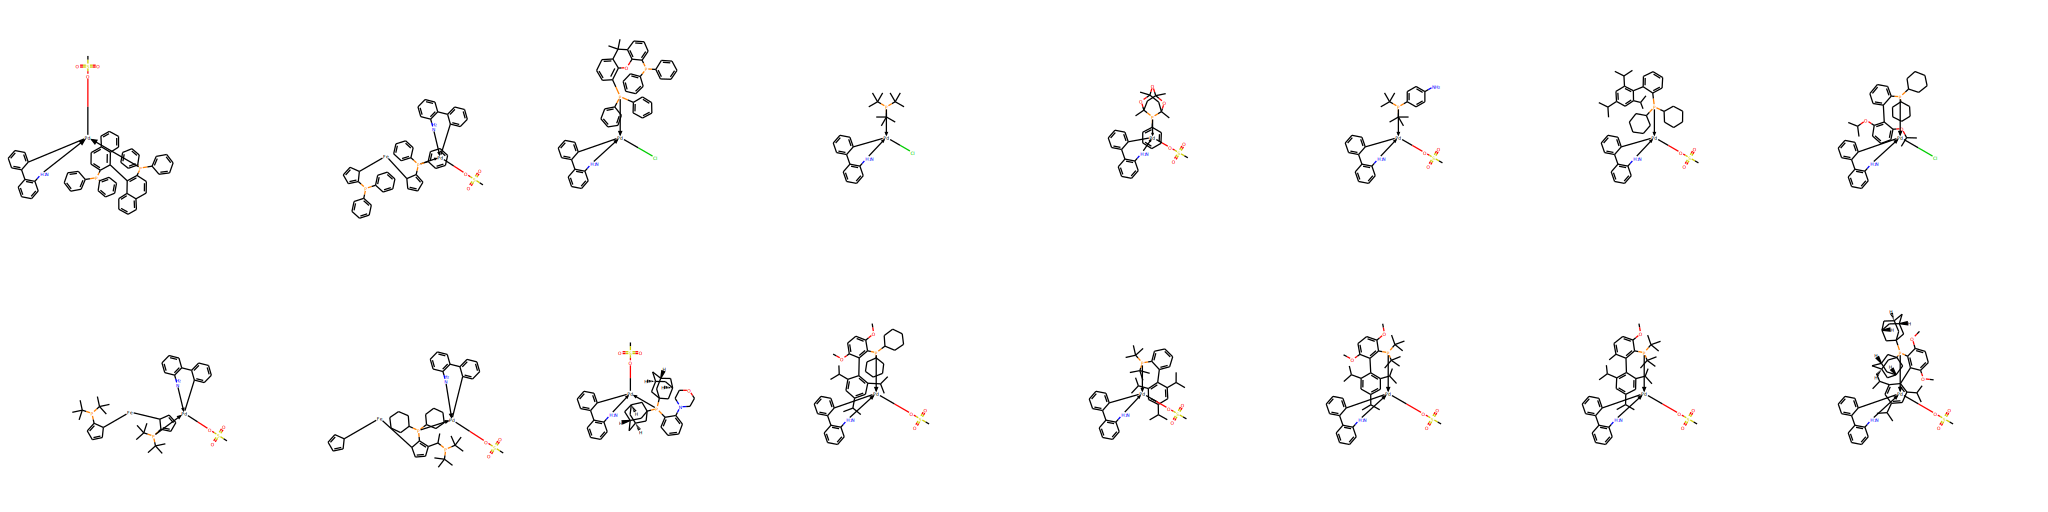

In [11]:
# Create list of mol objects
catalyst_mols = [
    Chem.MolFromSmiles(smiles) for smiles in
    smiles_data.loc[17:32, 'canonical_smiles']
] 
for mol in catalyst_mols:
    Chem.rdDepictor.Compute2DCoords(mol)
    
# Create grid drawing
# Can see neutral N, P, and Pd atoms with dative bonds from N and P to Pd
Chem.Draw.MolsToGridImage(
    catalyst_mols, molsPerRow=8, useSVG=True, subImgSize=(400,400)
)

## Add canonicalized SMILES to reagent_dict and create compound to SMILES mapping

In [12]:
# View current dictionary
reagent_dict

{'Electrophiles': {'bromide 22': 'placeholder'},
 'Nucleophiles': {'amine S1': 'placeholder',
  'aniline S2': 'placeholder',
  'amide S4': 'placeholder',
  'sulfonamide S5': 'placeholder',
  'aminopyridine S3': 'placeholder',
  'amidine S6': 'placeholder',
  'tBu carbamate S7': 'placeholder',
  'indazole S8': 'placeholder',
  'alcohol S9': 'placeholder',
  'phenol S10': 'placeholder',
  'thiophenol S11': 'placeholder',
  'phosphine S12': 'placeholder',
  'boronate S14/water': 'placeholder',
  'malonate S13': 'placeholder',
  'alkene S15': 'placeholder',
  'alkyne S16': 'placeholder'},
 'Catalysts': {'BINAP Pd G3 30': 'placeholder',
  'DPPF Pd G3 31': 'placeholder',
  'XantPhos Pd G2 32': 'placeholder',
  'tBu3P Pd G2 33': 'placeholder',
  'PPA Pd G3 34': 'placeholder',
  'Aphos Pd G3 35': 'placeholder',
  'Xphos Pd G3 36': 'placeholder',
  'RuPhos Pd G2 37': 'placeholder',
  'DTBPF Pd G3 38': 'placeholder',
  'J009  Pd G3 39': 'placeholder',
  'MorDalPhos Pd G3 40': 'placeholder',
  'B

In [13]:
# Fill in placeholder SMILES in reagent_dict with canonical SMILES
# and create mapping from dataset name to canonical SMILES
smiles_map = {}
for subclass, components in reagent_dict.items():
    for name in components.keys():
        # Two names are not caught due to extra spaces
        if name == 'J009  Pd G3 39':
            can_smiles = smiles_data.loc[26, 'canonical_smiles']
        elif name == 'tBuXPhos Pd G3  42':
            can_smiles = smiles_data.loc[29, 'canonical_smiles']
        else:
            can_smiles = smiles_data.loc[
                smiles_data['dataset_name'] == name,
                'canonical_smiles'].values[0]
        smiles_map[name] = can_smiles
        components[name] = can_smiles

# View completed dictionary
reagent_dict

{'Electrophiles': {'bromide 22': 'Brc1cccnc1'},
 'Nucleophiles': {'amine S1': 'CC(N)CCc1ccccc1',
  'aniline S2': 'Nc1ccccc1',
  'amide S4': 'NC(=O)c1ccccc1',
  'sulfonamide S5': 'NS(=O)(=O)c1ccccc1',
  'aminopyridine S3': 'Nc1ccc(-c2ccccc2)cn1',
  'amidine S6': 'N=C(N)Cc1ccccc1',
  'tBu carbamate S7': 'CC(C)(C)OC(N)=O',
  'indazole S8': 'c1ccc2[nH]ncc2c1',
  'alcohol S9': 'OCCCc1ccccc1',
  'phenol S10': 'Oc1ccccc1',
  'thiophenol S11': 'Sc1ccccc1',
  'phosphine S12': 'c1ccc(Pc2ccccc2)cc1',
  'boronate S14/water': 'CC1(C)OB(c2cnn(Cc3ccccc3)c2)OC1(C)C',
  'malonate S13': 'CCOC(=O)CC(=O)OCC',
  'alkene S15': 'CCOC(=O)/C=C/c1ccccc1',
  'alkyne S16': 'C#Cc1ccc(CCCC)cc1'},
 'Catalysts': {'BINAP Pd G3 30': 'CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)C2=C(C3=C(P(C4=CC=CC=C4)C4=CC=CC=C4)C=CC4=C3C=CC=C4)C3=C(C=CC=C3)C=C2)<-NC2=C(C=CC=C2)C2=CC=CC=C21',
  'DPPF Pd G3 31': 'CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)C2=CC=CC2[Fe]C2C=CC=C2P(C2=CC=CC=C2)C2=CC=CC=C2)<-NC2=C(C=CC=C2)C2=CC=CC=C21'

In [14]:
# View SMILES mapping
smiles_map

{'bromide 22': 'Brc1cccnc1',
 'amine S1': 'CC(N)CCc1ccccc1',
 'aniline S2': 'Nc1ccccc1',
 'amide S4': 'NC(=O)c1ccccc1',
 'sulfonamide S5': 'NS(=O)(=O)c1ccccc1',
 'aminopyridine S3': 'Nc1ccc(-c2ccccc2)cn1',
 'amidine S6': 'N=C(N)Cc1ccccc1',
 'tBu carbamate S7': 'CC(C)(C)OC(N)=O',
 'indazole S8': 'c1ccc2[nH]ncc2c1',
 'alcohol S9': 'OCCCc1ccccc1',
 'phenol S10': 'Oc1ccccc1',
 'thiophenol S11': 'Sc1ccccc1',
 'phosphine S12': 'c1ccc(Pc2ccccc2)cc1',
 'boronate S14/water': 'CC1(C)OB(c2cnn(Cc3ccccc3)c2)OC1(C)C',
 'malonate S13': 'CCOC(=O)CC(=O)OCC',
 'alkene S15': 'CCOC(=O)/C=C/c1ccccc1',
 'alkyne S16': 'C#Cc1ccc(CCCC)cc1',
 'BINAP Pd G3 30': 'CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)C2=C(C3=C(P(C4=CC=CC=C4)C4=CC=CC=C4)C=CC4=C3C=CC=C4)C3=C(C=CC=C3)C=C2)<-NC2=C(C=CC=C2)C2=CC=CC=C21',
 'DPPF Pd G3 31': 'CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)C2=CC=CC2[Fe]C2C=CC=C2P(C2=CC=CC=C2)C2=CC=CC=C2)<-NC2=C(C=CC=C2)C2=CC=CC=C21',
 'XantPhos Pd G2 32': 'CC1(C)C2=CC=CC(P(C3=CC=CC=C3)(C3=CC=CC=C3)

## Add component SMILES and yield columns to data

In [15]:
# Make list of columns to be mapped to corresponding SMILES
subclasses = ['Electrophile', 'Nucleophile', 'Catalyst', 'Base', 'Product']

# Create new columns using smiles_map
for subclass in subclasses:
    data[f'{subclass}_SMILES'] = data[subclass].map(smiles_map)

# View changes
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,...,Prod,Nu,Pd/IS,Product,Reaction_type,Electrophile_SMILES,Nucleophile_SMILES,Catalyst_SMILES,Base_SMILES,Product_SMILES
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.33032,...,0.000000e+00,2.638835e+06,0.000000,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,C1CCC2=NCCCN2CC1,CC(CCc1ccccc1)Nc1cccnc1
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.34177,...,0.000000e+00,2.474074e+06,0.000000,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CN1CCCN2CCCN=C12,CC(CCc1ccccc1)Nc1cccnc1
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.13944,...,0.000000e+00,2.387052e+06,0.000000,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CN(C)C(=NC(C)(C)C)N(C)C,CC(CCc1ccccc1)Nc1cccnc1
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.17048,...,3.268438e+04,2.511884e+06,0.137295,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CC(CCc1ccccc1)Nc1cccnc1
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232566.53610,...,0.000000e+00,2.576513e+06,0.000000,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CC(CCc1ccccc1)Nc1cccnc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178233.56101,...,3.046576e+06,NaN,17.093165,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CN1CCCN2CCCN=C12,CCCCc1ccc(C#Cc2cccnc2)cc1
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229583.53543,...,2.789535e+06,NaN,12.150413,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CN(C)C(=NC(C)(C)C)N(C)C,CCCCc1ccc(C#Cc2cccnc2)cc1
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.15883,...,4.537288e+05,NaN,2.244058,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CCCCc1ccc(C#Cc2cccnc2)cc1
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201367.67531,...,1.109048e+06,NaN,5.507575,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CCCCc1ccc(C#Cc2cccnc2)cc1


In [16]:
# Check yield distributions
data.describe()

,IS,ArBr,Prod,Nu,Pd/IS
count,1.536000e+03,1.536000e+03,1.536000e+03,6.720000e+02,1531.000000
mean,2.387198e+05,8.901066e+05,4.282438e+05,2.058694e+06,2.057352
std,1.145788e+05,3.836603e+05,9.515332e+05,7.573593e+05,4.755104
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.931701e+05,7.479278e+05,0.000000e+00,1.623828e+06,0.000000
50%,2.191729e+05,1.023685e+06,0.000000e+00,2.175684e+06,0.000000
75%,2.396104e+05,1.126468e+06,2.587670e+05,2.597350e+06,1.159855
max,1.274687e+06,2.181530e+06,6.411983e+06,5.094171e+06,39.811353


In [17]:
# Above table indicates there are missing values; find where
# Below table indicates 'Nu' and 'Pd/IS' absorption measurments are missing
# from many reactions
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Plate Position       1536 non-null   object 
 1   Electrophile         1536 non-null   object 
 2   Electrophile charge  1536 non-null   object 
 3   Nucleophile          1536 non-null   object 
 4   Nucleophile charge   1536 non-null   object 
 5   Catalyst             1536 non-null   object 
 6   Catalyst charge      1536 non-null   object 
 7   Base                 1536 non-null   object 
 8   Base charge          1536 non-null   object 
 9   IS                   1536 non-null   float64
 10  ArBr                 1536 non-null   float64
 11  Prod                 1536 non-null   float64
 12  Nu                   672 non-null    float64
 13  Pd/IS                1531 non-null   float64
 14  Product              1536 non-null   object 
 15  Reaction_type        1536 non-null   o

In [18]:
# Going to assume missing values are undetected, i.e., 0 absorbtion
# Fill in missing values with 0 for 'IS', 'ArBr', 'Prod', 'Nu', 'Pd/IS'
for column in ['IS', 'ArBr', 'Prod', 'Nu', 'Pd/IS']:
    data[column] = data[column].fillna(0)

# Add explicit yield columns, dividing 'IS' by .03 as procedure claims
# final IS loading is 3 mol % relative to ArBr. Paper uses Pd/IS to directly
# compare performance of each reaction conditions, but is not actually a
# reaction yield measurement
data['Product_yield'] = round(((data['Prod']/(data['IS']/0.03))*100), 2)
data['ArBr_yield'] = round(((data['ArBr']/(data['IS']/0.03))*100), 2)
data['Nu_yield'] = round(((data['Nu']/(data['IS']/0.03))*100), 2)

# Handle any cases where 'IS' = 0 and 0 division failed
# Reset any yields greater than 105% (ORD limit)
for column in ['Product_yield', 'ArBr_yield', 'Nu_yield']:
    data[column] = data[column].fillna(0)
    #data.loc[data[column] > 105, column] = 105

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Plate Position       1536 non-null   object 
 1   Electrophile         1536 non-null   object 
 2   Electrophile charge  1536 non-null   object 
 3   Nucleophile          1536 non-null   object 
 4   Nucleophile charge   1536 non-null   object 
 5   Catalyst             1536 non-null   object 
 6   Catalyst charge      1536 non-null   object 
 7   Base                 1536 non-null   object 
 8   Base charge          1536 non-null   object 
 9   IS                   1536 non-null   float64
 10  ArBr                 1536 non-null   float64
 11  Prod                 1536 non-null   float64
 12  Nu                   1536 non-null   float64
 13  Pd/IS                1536 non-null   float64
 14  Product              1536 non-null   object 
 15  Reaction_type        1536 non-null   o

In [19]:
# View final dataset
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,...,Product,Reaction_type,Electrophile_SMILES,Nucleophile_SMILES,Catalyst_SMILES,Base_SMILES,Product_SMILES,Product_yield,ArBr_yield,Nu_yield
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.33032,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,C1CCC2=NCCCN2CC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,15.07,32.97
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.34177,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CN1CCCN2CCCN=C12,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.20,31.09
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.13944,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CN(C)C(=NC(C)(C)C)N(C)C,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.04,30.47
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.17048,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CC(CCc1ccccc1)Nc1cccnc1,0.41,14.00,31.65
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232566.53610,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.40,33.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178233.56101,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CN1CCCN2CCCN=C12,CCCCc1ccc(C#Cc2cccnc2)cc1,51.28,0.00,0.00
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229583.53543,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CN(C)C(=NC(C)(C)C)N(C)C,CCCCc1ccc(C#Cc2cccnc2)cc1,36.45,3.32,0.00
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.15883,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CCCCc1ccc(C#Cc2cccnc2)cc1,6.73,12.10,0.00
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201367.67531,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CCCCc1ccc(C#Cc2cccnc2)cc1,16.52,9.28,0.00


In [20]:
# Show final dataset statistics
data.describe()

,IS,ArBr,Prod,Nu,Pd/IS,Product_yield,ArBr_yield,Nu_yield
count,1.536000e+03,1.536000e+03,1.536000e+03,1.536000e+03,1536.000000,1536.000000,1536.000000,1536.000000
mean,2.387198e+05,8.901066e+05,4.282438e+05,9.006787e+05,2.050654,6.152031,12.522422,10.991686
std,1.145788e+05,3.836603e+05,9.515332e+05,1.137724e+06,4.748800,14.246570,7.543525,14.342438
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.931701e+05,7.479278e+05,0.000000e+00,0.000000e+00,0.000000,0.000000,8.247500,0.000000
50%,2.191729e+05,1.023685e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,13.560000,0.000000
75%,2.396104e+05,1.126468e+06,2.587670e+05,2.093107e+06,1.130823,3.392500,16.390000,25.692500
max,1.274687e+06,2.181530e+06,6.411983e+06,5.094171e+06,39.811353,119.430000,92.860000,86.120000


# Define a single reaction

This experiment details the screening of cross-coupling reactions between one aryl halide with 16 nucleophiles using 16 different precatalysts and 6 bases (1536 reactions)

The general procedure from the SI is as follows:

"**Experiment 2. 1536-Well Plate Screening of Pd Cross-Coupling Reactions of 3- Bromopyridine 22 with 16 Nucleophiles (16 Precatalysts, 6 Bases)**

A 1536-well plate experiment examining the reactivity of 3-bromopyridine 22 with 16 different classes of nucleophiles under 96 Pd cross-coupling reaction conditions was run at 100 nanomolar scale by dosing from a 384-well plate containing stock solutions of the starting materials and reagents into a 1536-Well Plate by Mosquito.<br>

**Procedure.** Stock solutions of each of the reaction components were prepared as follows: Pd- precatalysts (**30-45**, 0.04 M in DMSO), aryl halide (**22**, 0.4 M in DMSO), nucleophiles (**S1-S16**, 0.6 M in DMSO), and base (**24-29**, 0.8 M in DMSO). Each of the solutions was dispensed in 75 uL charges to a 384-well plate (source plate map is shown in Figure S8, components listed in Table S2).<br>

The Mosquito was used to combine the source plate solutions by multi-aspiration of 250 nL of each of the four reaction components and then to dose the resulting reaction mixture (1 uL) into a 1536-well plate. Once the 1536-well plate was fully dosed the plate was covered by a PFA film and clamped to minimize low-level component volatility. The plate was then allowed to sit at room temperature for 22 hours. Using the Mosquito, the plate was then quenched with 3 uL of a DMSO stock solution of acetic 5% acid and biphenyl (to give 3 mol% biphenyl relative to **22**), which was transferred from a 384-well source plate. The Mosquito then sampled 1 uL from the quenched reaction plate into 4 x 384-well plates containing 75 uL of DMSO per well. The Mosquito mixing feature was used three times per aspiration and dispense steps in order to ensure homogeneity of the analytical sample. The 384-well plate was then heat-sealed and subjected to chromatographic analysis by a Waters UPLC Instrument. The ratio of the LC area counts of product over internal standard was used to directly compare the relative performance of these reactions."

In [21]:
# Calculate stoichiometry
# List component stock solution concentrations (in M or nmol/nL) 
electrophile_stock_conc = 0.4
nucleophile_stock_conc = 0.6
base_stock_conc = 0.8
catalyst_stock_conc = 0.04

# Calculate nmol of each component added
electrophile_nmol = electrophile_stock_conc * 250
nucleophile_nmol = nucleophile_stock_conc * 250
base_nmol = base_stock_conc * 250
catalyst_nmol = catalyst_stock_conc * 250

# Show values
print(electrophile_nmol, nucleophile_nmol, base_nmol, catalyst_nmol)

100.0 150.0 200.0 10.0


### Set up reaction in flow of Reaction message
1. Define reaction
2. Add identifiers
3. Add inputs
4. Describe setup
5. Describe conditions
6. Add notes
7. Add observations
8. Describe workup
9. Describe outcomes
10. Add provenance

#### 1. Define reaction

In [22]:
# Initialize Reaction
reaction = reaction_pb2.Reaction()

#### 2. Add identifiers

In [23]:
reaction.identifiers.add(value=r'placeholder', type='NAME')

type: NAME
value: "placeholder"

#### 3. Add inputs

In [24]:
# Reactant 1
reaction.inputs['electrophile'].addition_order = 1
solute = reaction.inputs['electrophile'].components.add()
solvent = reaction.inputs['electrophile'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reactant',
    amount='100 nmol', prep=None, is_limiting=True,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

# Reactant 2
reaction.inputs['nucleophile'].addition_order = 1
solute = reaction.inputs['nucleophile'].components.add()
solvent = reaction.inputs['nucleophile'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reactant',
    amount='150 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

# Reagent 1 = Base
reaction.inputs['base'].addition_order = 1
solute = reaction.inputs['base'].components.add()
solvent = reaction.inputs['base'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reagent',
    amount='200 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

# Catalyst
reaction.inputs['catalyst'].addition_order = 1
solute = reaction.inputs['catalyst'].components.add()
solvent = reaction.inputs['catalyst'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reagent',
    amount='10 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

#### 4. Describe setup
From the SI: "All reactions, including parallel synthesis, were performed inside an MBraun glovebox operating with a constant N2-purge (oxygen typically <5 ppm). The experimental design was accomplished using Free-Slate Library Studio."<br>
"**Nanomolar Scale Chemistry Experiments**. Nanoscale reactions (50-100 nmol) were run using Corning® 1536-well plates (Corning EchoTM qualified, Cat. No. 3730, Cyclic Olefin-Copolymer COC, 12.5 μL-wells, flat bottom, clear) as reaction plates, and typically with AdvantageTM 384- well plates (Analytical-Sales, Cat. No. 38120, polypropylene, 120 μL-wells, flat bottom, clear) used as solution source plates for stock solutions and for analytical plates on UPLC-MS or HPLC-MS equipment. Dosing of reaction components into the 384- and 1536-well plates was accomplished in the glovebox using a Mosquito® HTS liquid handling robot (Figure S1, TTP Labtech, 4.5 mm pitch tip spool) with no special modifications, and using the TTP Labtech native software. Upon dosing, the 1536-well plates were covered by a perfluoroalkoxy alkane (PFA) mat (Analytical-Sales, Cat. No. 96981), followed by a silicon rubber mat (Analytical- Sales, Cat. No. 96982) and then secured with a clamp (Arctic White, Cat. No. AWSC-051001)."

In [25]:
# Reactions performed in 1536-well plate
reaction.setup.vessel.CopyFrom(
    reaction_pb2.Vessel(
        type=dict(type='WELL_PLATE', details=(
            r'Corning Echo qualified,'
            r' Cat. No. 3730')), 
        material=dict(type='PLASTIC', details='Cyclic Olefin-Copolymer'),
        volume=unit_resolver.resolve('12.5 uL'),
    )
)

# Add vessel attachments
reaction.setup.vessel.attachments.add(
    type='MAT', details=(
        r'perfluoroalkoxy alkane (PFA)'
        r' mat (Analytical-Sales, Cat. No. 96981)'
    )
)

reaction.setup.vessel.attachments.add(
    type='MAT', details=(
        r'silicon rubber mat (Analytical-Sales, Cat. No. 96982)'
    )
)

reaction.setup.vessel.attachments.add(
    type='CUSTOM', details=(
        r'clamp (Arctic White, Cat. No. AWSC-051001)'
    )
)

# Specify reaction environment
reaction.setup.environment.CopyFrom(
    reaction_pb2.ReactionSetup.ReactionEnvironment(
        type='GLOVE_BOX', details=(
            r'MBraun glovebox operating with'
            r' a constant N2-purge (oxygen typically <5 ppm)'
        )
    )
)

# Specify automation
reaction.setup.is_automated = True
reaction.setup.automation_platform = (
    r'Mosquito(R) HTS liquid handling robot;' 
    r' TTP Labtech native software;' 
    r' Free-Slate Library Studio'
)

#### 5. Describe conditions

In [26]:
# Reactions allowed to sit ambiently for 22 hours
reaction.conditions.temperature.CopyFrom(
    reaction_pb2.TemperatureConditions(
        control=(dict(type='AMBIENT',
                      details=(
                          r'The plate was then allowed to sit at'
                          r' room temperature for 22 hours'))
    )
))

# Experiment run at atmospheric pressure, plate sealed with silicon mats
reaction.conditions.pressure.CopyFrom(
    reaction_pb2.PressureConditions(
        control=(dict(type='SEALED', details=(
            r'The 1536-well plates were covered by a'
            r' perfluoroalkoxy alkane (PFA) mat (Analytical-Sales,'
            r' Cat. No. 96981), followed by a silicon rubber mat'
            r' (Analytical- Sales, Cat. No. 96982) and then secured'
            r' with a clamp (Arctic White, Cat. No. AWSC-051001)'))), 
        atmosphere=(dict(type='NITROGEN'))
    )
)

# No stirring used
reaction.conditions.stirring.CopyFrom(
    reaction_pb2.StirringConditions(
        method=(dict(type='NONE'))
    )
)

#### 6. Add notes

In [27]:
# Reaction prepared in glove box, presumed sensitivity
reaction.notes.is_sensitive_to_moisture = True
reaction.notes.is_sensitive_to_oxygen = True

# Authors note reactions are homogeneous
reaction.notes.is_heterogeneous = False

# No safety notes
reaction.notes.safety_notes = ''

# Additional sentence explaining how the components are dosed (aspiration)
reaction.notes.procedure_details = (
    r'The Mosquito was used to combine the'
    r' source plate solutions by multi-aspiration of 250 nL of each of the'
    r' four reaction components and then to dose the resulting reaction'
    r' mixture (1 uL) into a 1536-well plate'
)

#### 7. Add observations
Images included in the SI showing reaction plate setup.

In [28]:
# Create image data message for setup pictures
dosed_plate = reaction_pb2.Data(
    url='https://postimg.cc/fk783Pbw',
    description='fully dosed plate',
    format='png'
)
sealed_plate = reaction_pb2.Data(
    url='https://postimg.cc/YjBXC7Mn',
    description='sealed plate',
    format='png'
)

# Add images as observations
reaction.observations.add(
    time=(dict(value=0, units='HOUR')),
    comment='fully dosed 1536 reaction well plate',
    image=dosed_plate)
reaction.observations.add(
    time=(dict(value=0, units='HOUR')),
    comment='clamped 1536-wp - perspective view',
    image=sealed_plate)

time {
  value: 0.0
  units: HOUR
}
comment: "clamped 1536-wp - perspective view"
image {
  url: "https://postimg.cc/YjBXC7Mn"
  description: "sealed plate"
  format: "png"
}

#### 8. Describe workup
From the SI: "Using the Mosquito, the plate was then quenched with 3 uL of a DMSO stock solution of acetic 5% acid and biphenyl (to give 3 mol% biphenyl relative to 22), which was transferred from a 384-well source plate. The Mosquito then sampled 1 uL from the quenched reaction plate into 4 x 384-well plates containing 75 uL of DMSO per well. The Mosquito mixing feature was used three times per aspiration and dispense steps in order to ensure homogeneity of the analytical sample."

In [29]:
# Create quench solution as workup input
workup = reaction.workup.add(
    type='ADDITION',
    stirring=(dict(method=(dict(
        type='AGITATION', 
        details='The Mosquito mixing feature was used three times')))),
    is_automated=True
)

# Add components (assuming biphenyl to be 100 nmol * 3 mol % = 3 nmol)
workup.input.components.add().CopyFrom(message_helpers.build_compound(
    name='acetic acid', smiles='CC(=O)O', role='workup',
    amount='0.15 uL', prep=None, is_limiting=False,
    prep_details=None,
))
workup.input.components.add().CopyFrom(message_helpers.build_compound(
    name='biphenyl', smiles='c1ccc(-c2ccccc2)cc1', role='internal_standard',
    amount='3 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
workup.input.components.add().CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='workup',
    amount='2.85 uL', prep=None, is_limiting=False,
    prep_details=None,
)) 

# Add aliquot step
aliquot = reaction.workup.add(
    type='ALIQUOT',
    stirring=(dict(method=(dict(
        type='AGITATION', 
        details='The Mosquito mixing feature was used three times')))),
    is_automated=True,
    volume=reaction_pb2.Volume(value=1, units='MICROLITER')
)

# Create dilution solvent as workup input 
dilution = reaction.workup.add(
    type='ADDITION',
    stirring=(dict(method=(dict(
        type='AGITATION', 
        details='The Mosquito mixing feature was used three times')))),
    is_automated=True
)

# Add DMSO component 
dilution.input.components.add().CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='workup',
    amount='75 uL', prep=None, is_limiting=False,
    prep_details=None,
))

#### 9. Describe outcomes
From the SI: "The plate was then allowed to sit at room temperature for 22 hours."<br>
"The 384-well plate was then heat-sealed and subjected to chromatographic analysis by a Waters UPLC Instrument. The ratio of the LC area counts of product over internal standard was used to directly compare the relative performance of these reactions." <br>
**The authors do not directly report reaction yields, but compare their relative performances by ratios of "LC area counts of product over internal standard". We calculate reaction yields here with the assumption that the internal standard is present in 3 mol % as they note, and that the product and internal standard have equivalent response factors under the absorption method used. This may not be true, and some yields are > 100%, but there is no other direct quantitative reaction performance metric provided.**

In [30]:
# Add outcome
outcome = reaction.outcomes.add(
    reaction_time=unit_resolver.resolve('22 hours'),
)

# Add analyses
# UPLC
outcome.analyses['UPLC'].type = reaction_pb2.ReactionAnalysis.LC
outcome.analyses['UPLC'].details = (
    r'Column: Acquity UPLC BEH C18 1.7um 2.1x50mm (Part # 186002350),' 
    r' pH 3.5 Stock Solution: 12.6g ammonium formate + 7.9ml formic acid' 
    r' to 1L water, Mobile Phase A: 40ml pH 3.5 stock solution + 3960ml Water,' 
    r' Mobile Phase B: 40ml pH 3.5 stock solution + 360ml Water + 3600ml ACN,' 
    r' Strong Wash: 300ml IPA + 693ml ACN + 7ml pH 3.5 stock solution,' 
    r' Weak Wash: 99ml ACN + 891ml Water + 10ml pH 3.5 stock solution.' 
    r' The instrument was equipped with an SQD detector with electrospray' 
    r' ionization (ESI) source in the positive mode. High throughput data' 
    r' analysis to produce Excel spreadsheets was done with' 
    r' Virscidian Analytical StudioTM software.'
)
outcome.analyses['UPLC'].instrument_manufacturer = 'Waters'
outcome.analyses['UPLC'].uses_internal_standard = True
# Authentic standards were made for product identification 
# (i.e., chromatogram comparison), not assay calibration/quantification
# Also, still ambiguous about which species uses_authentic_standard applies to
# (three are analyzed here), assuming all are known/identified properly 
outcome.analyses['UPLC'].uses_authentic_standard = True
# Add data from LC traces
outcome.analyses['UPLC'].processed_data['product LC area count'].float_value = 0 # placeholder
outcome.analyses['UPLC'].processed_data['electrophile LC area count'].float_value = 0 # placeholder
outcome.analyses['UPLC'].processed_data['nucleophile LC area count'].float_value = 0 # placeholder
outcome.analyses['UPLC'].processed_data['internal_standard LC area count'].float_value = 0 # placeholder

# Create reaction products
# Desired product
product = outcome.products.add() 
product.compound.identifiers.add().CopyFrom(
    reaction_pb2.CompoundIdentifier(value=r'placeholder', type='SMILES')
)
product.is_desired_product = True
product.analysis_identity.append('UPLC')
product.analysis_yield.append('UPLC')

# Remaining starting material (electrophile or ArBr)
electrophile = outcome.products.add() 
electrophile.compound.identifiers.add().CopyFrom(
    reaction_pb2.CompoundIdentifier(value=r'placeholder', type='SMILES')
)
electrophile.is_desired_product = False
electrophile.analysis_identity.append('UPLC')
electrophile.analysis_yield.append('UPLC')

# Remaining coupling partner (nucleophile)
nucleophile = outcome.products.add() 
nucleophile.compound.identifiers.add().CopyFrom(
    reaction_pb2.CompoundIdentifier(value=r'placeholder', type='SMILES')
)
nucleophile.is_desired_product = False
nucleophile.analysis_identity.append('UPLC')
nucleophile.analysis_yield.append('UPLC')

#### 10. Add provenance

In [31]:
# Reaction provenance
reaction.provenance.city = r'Rahway, NJ'
reaction.provenance.doi = r'10.1126/science.1259203'
reaction.provenance.publication_url = r'https://science.sciencemag.org/content/347/6217/49'
reaction.provenance.record_created.time.value = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
reaction.provenance.record_created.person.CopyFrom(reaction_pb2.Person(
    name='Michael R. Maser', organization='Caltech', orcid='0000-0001-7895-7804', email='mmaser@caltech.edu'
))

Validate and examine this final prototypical reaction entry

In [32]:
# Validation fails with 'placeholder' SMILES
#validations.validate_message(reaction)

# Just print
print(reaction)

identifiers {
  type: NAME
  value: "placeholder"
}
inputs {
  key: "base"
  value {
    components {
      identifiers {
        type: SMILES
        value: "placeholder"
      }
      identifiers {
        type: NAME
        value: "placeholder"
      }
      moles {
        value: 200.0
        units: NANOMOLE
      }
      reaction_role: REAGENT
      is_limiting: false
    }
    components {
      identifiers {
        type: SMILES
        value: "CS(C)=O"
      }
      identifiers {
        type: NAME
        value: "DMSO"
      }
      volume {
        value: 0.25
        units: MICROLITER
      }
      reaction_role: SOLVENT
      is_limiting: false
      volume_includes_solutes: true
    }
    addition_order: 1
  }
}
inputs {
  key: "catalyst"
  value {
    components {
      identifiers {
        type: SMILES
        value: "placeholder"
      }
      identifiers {
        type: NAME
        value: "placeholder"
      }
      moles {
        value: 10.0
        units: NANOMOL

# Full HTE Data Set

In [33]:
# Check current dataset
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,...,Product,Reaction_type,Electrophile_SMILES,Nucleophile_SMILES,Catalyst_SMILES,Base_SMILES,Product_SMILES,Product_yield,ArBr_yield,Nu_yield
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.33032,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,C1CCC2=NCCCN2CC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,15.07,32.97
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.34177,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CN1CCCN2CCCN=C12,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.20,31.09
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.13944,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CN(C)C(=NC(C)(C)C)N(C)C,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.04,30.47
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.17048,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CC(CCc1ccccc1)Nc1cccnc1,0.41,14.00,31.65
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232566.53610,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd]1(<-P(C2=CC=CC=C2)(C2=CC=CC=C2)...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.40,33.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178233.56101,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CN1CCCN2CCCN=C12,CCCCc1ccc(C#Cc2cccnc2)cc1,51.28,0.00,0.00
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229583.53543,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CN(C)C(=NC(C)(C)C)N(C)C,CCCCc1ccc(C#Cc2cccnc2)cc1,36.45,3.32,0.00
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.15883,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CCCCc1ccc(C#Cc2cccnc2)cc1,6.73,12.10,0.00
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201367.67531,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COC1=CC=C(OC)C(P(C23C[C@H]4C[C@@H](C2)C[C@@H](...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CCCCc1ccc(C#Cc2cccnc2)cc1,16.52,9.28,0.00


In [34]:
reactions = []
for _,row in tqdm(data.iterrows()):
    new_reaction = reaction_pb2.Reaction()
    new_reaction.CopyFrom(reaction)
    
    # Update name
    new_reaction.identifiers[0].value = row['Reaction_type']
    
    # Update electrophile name & SMILES
    new_reaction.inputs['electrophile'].components[0].identifiers[0].value = row['Electrophile_SMILES']
    new_reaction.inputs['electrophile'].components[0].identifiers[1].value = row['Electrophile']
    
    # Update nucleophile name & SMILES
    new_reaction.inputs['nucleophile'].components[0].identifiers[0].value = row['Nucleophile_SMILES']
    new_reaction.inputs['nucleophile'].components[0].identifiers[1].value = row['Nucleophile']
    
    # Add water as reactant if using boronate S14 nucleophile
    if row['Nucleophile'] == 'boronate S14/water':
        water = new_reaction.inputs['nucleophile'].components.add()
        water.CopyFrom(message_helpers.build_compound(
            name='water', smiles='O', role='reactant',
            amount='400 nmol', prep=None, is_limiting=False,
            prep_details=None,
        ))
        
    # Update base
    new_reaction.inputs['base'].components[0].identifiers[0].value = row['Base_SMILES']
    new_reaction.inputs['base'].components[0].identifiers[1].value = row['Base']
    
    # Update catalyst
    new_reaction.inputs['catalyst'].components[0].identifiers[0].value = row['Catalyst_SMILES']
    new_reaction.inputs['catalyst'].components[0].identifiers[1].value = row['Catalyst']
    
    # Update product_0 and record product yield and LC area count
    new_reaction.outcomes[0].products[0].compound.identifiers[0].value = row['Product_SMILES']
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['product LC area count'].float_value = (
        row['Prod'])
    
    # Update product_1 and record remaining electrophile yield and LC area count
    new_reaction.outcomes[0].products[1].compound.identifiers[0].value = row['Electrophile_SMILES']
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['electrophile LC area count'].float_value = (
        row['ArBr'])
    
    # Update product_2 and record remaining electrophile yield and LC area count
    new_reaction.outcomes[0].products[2].compound.identifiers[0].value = row['Nucleophile_SMILES']
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['nucleophile LC area count'].float_value = (
        row['Nu'])
    
    # Record internal standard LC area count
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['internal_standard LC area count'].float_value = (
        row['IS'])
    
    # Validate
    errors = validations.validate_message(new_reaction)
    for error in errors.errors:
        print(error)
    # Get warnings for specifying temperature setpoint
    # Silencing for now, don't want to estimate room temperature in glove box
    #for warning in errors.warnings:
    #    print(warning)
    
    # Append
    reactions.append(new_reaction)

1536it [00:11, 129.80it/s]


In [35]:
# Verify full dataset was written
print(f'Generated {len(reactions)} reactions')

Generated 1536 reactions


In [36]:
# Inspect random reaction from this set
random_index = np.random.randint(len(reactions))
print(f'Reaction entry {random_index}:')
reactions[random_index]

Reaction entry 1236:


identifiers {
  type: NAME
  value: "Suzuki-Miyaura coupling"
}
inputs {
  key: "base"
  value {
    components {
      identifiers {
        type: SMILES
        value: "C1CCC2=NCCCN2CC1"
      }
      identifiers {
        type: NAME
        value: "DBU 24"
      }
      moles {
        value: 200.0
        units: NANOMOLE
      }
      reaction_role: REAGENT
      is_limiting: false
    }
    components {
      identifiers {
        type: SMILES
        value: "CS(C)=O"
      }
      identifiers {
        type: NAME
        value: "DMSO"
      }
      volume {
        value: 0.25
        units: MICROLITER
      }
      reaction_role: SOLVENT
      is_limiting: false
      volume_includes_solutes: true
    }
    addition_order: 1
  }
}
inputs {
  key: "catalyst"
  value {
    components {
      identifiers {
        type: SMILES
        value: "COC1=CC=C(C)C(C2=C(C(C)C)C=C(C(C)C)C=C2C(C)C)=C1P(C(C)(C)C)(C(C)(C)C)->[Pd]1(OS(C)(=O)=O)<-NC2=C(C=CC=C2)C2=CC=CC=C21"
      }
      identifi

### Package reactions into a dataset

In [37]:
# Create dataset message containing reaction list
dataset = dataset_pb2.Dataset(
    name='HTE Pd-catalyzed cross-coupling screen',
    description='Reactions from Experiment 2 of DOI: 10.1126/science.1259203',
    reactions=reactions,    
)

# Write reaction and dataset to file
#message_helpers.write_message(reaction, 'Santanilla_experiment2_reaction.pbtxt')
#message_helpers.write_message(dataset, 'Santanilla_experiment2_dataset.pbtxt')